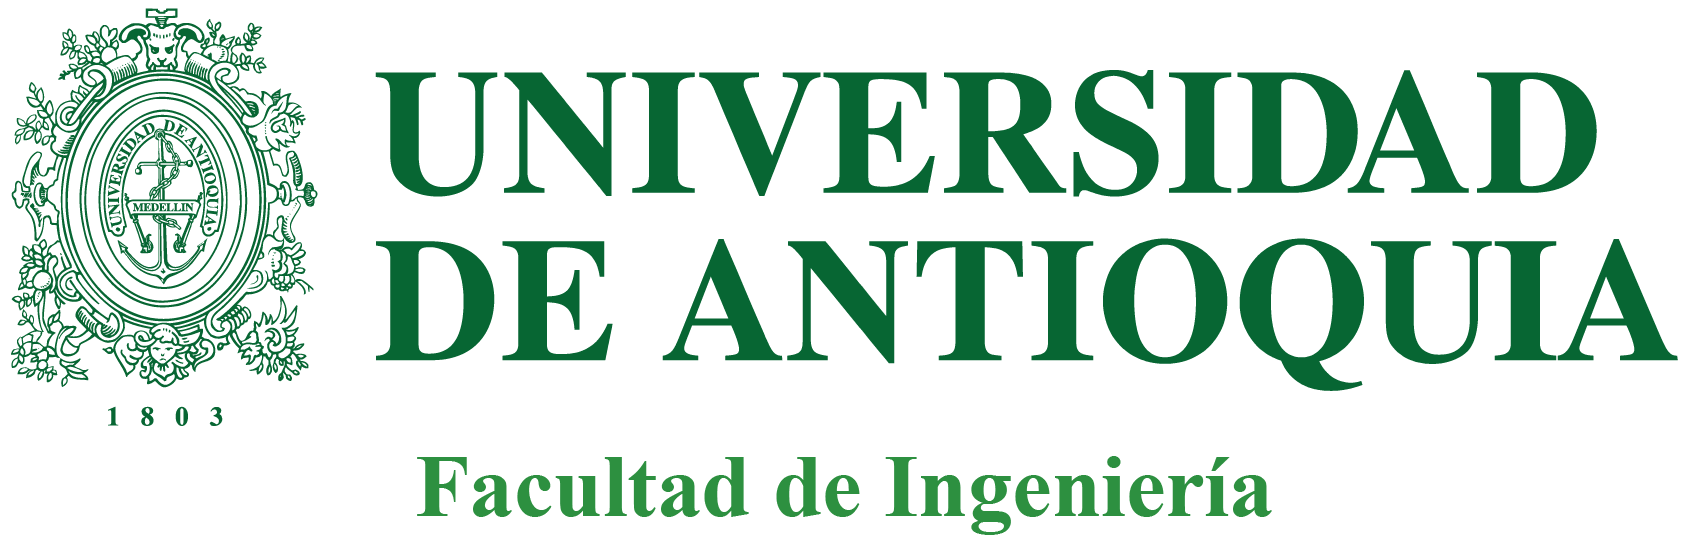
---

**Especialización en Analítica y Ciencia de Datos - Analytics & Data Science**

**Universidad de Antioquia**

**2024**

**Melissa Ortega Alzate**

---

# Redes neuronales convolucionales para la detección de Salmonella *spp.* en aves de corral
### Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry

This notebook is the second part of a series of four notebooks associated with the project "Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry". The other notebooks can be found in the associated GitHub repository linked below.

<div style="display: flex; align-items: center; justify-content: flex-end; position: fixed; bottom: 10px; right: 10px;">
  <a href="https://colab.research.google.com/github/tu-usuario/tu-repositorio" style="margin-right: 15px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 25px;">
  </a>
  <a href="https://github.com/melissaortegaa/monografia" style="margin-right: 15px;">
    <img src="https://img.shields.io/badge/GitHub-000?logo=github&logoColor=fff&style=flat" alt="View on GitHub" style="height: 25px;">
  </a>
</div>

## Objectives

1. Design and train a convolutional neural network (CNN) using TensorFlow and Keras to classify images into two categories: Healthy or Salmonella.
2. Compare the designed architecture by changing model compilation parameters such as the optimizer (Adam or RMSprop) with two different learning rates, as well as the implementation of Dropout and regularizers (L1, L2, L1_L2, or none).
3. Evaluate the performance of each model using accuracy, recall and confusion matrices to identify which parameter combination provides the best performance.

## Summary

In this notebook, twelve convolutional neural network (CNN) models are designed and compared to classify images into two categories: Healthy or Salmonella. The models are compared in terms of accuracy, using different combinations of optimizers (Adam and RMSprop), regularizers (L1, L2, L1_L2, and none), and Dropout layers. The performance of each model is evaluated using confusion matrices and performance metrics such as accuracy and recall.

| Model | Loss                     | Optimizer             | Dropout |Regularizer |
|-------|--------------------------|-----------------------|---------|------------|
| 1     | Categorical Crossentropy | Adam (lr = 0.001)     | 0.5     | L2       |
| 2     | Categorical Crossentropy | Adam (lr = 0.0001)    | 0.5     | L2       |
| 3     | Categorical Crossentropy | Adam (lr = 0.001)     | N/A     | L2       |
| 4     | Categorical Crossentropy | Adam (lr = 0.001)     | 0.5     | L1       |
| 5     | Categorical Crossentropy | Adam (lr = 0.001)     | 0.5     | L1, L2   |
| 6     | Categorical Crossentropy | Adam (lr = 0.001)     | 0.5     | None     |
| 7     | Categorical Crossentropy | RMSprop (lr = 0.001)  | 0.5     | L2       |
| 8     | Categorical Crossentropy | RMSprop (lr = 0.0001) | 0.5     | L2       |
| 9     | Categorical Crossentropy | RMSprop (lr = 0.001)  | N/A     | L2       |
| 10    | Categorical Crossentropy | RMSprop (lr = 0.001)  | 0.5     | L1       |
| 11    | Categorical Crossentropy | RMSprop (lr = 0.001)  | 0.5     | L1, L2   |
| 12    | Categorical Crossentropy | RMSprop (lr = 0.001)  | 0.5     | None     |




# Libraries & Settings

### Imports

In [1]:
# Standard library imports
import os
import random
import zipfile
import sys
import warnings
import datetime, time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation and processing
import numpy as np
import pandas as pd

# Image visualization
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import matplotlib.image as mpimg

# Deep learning frameworks and utilities
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend as K

# Clear any previous Keras session to avoid clutter from old models
K.clear_session()

# Callbacks, regularizer and optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop

# Metrics and evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ignore warnings
warnings.filterwarnings("ignore")

# Set environment variables to reduce TensorFlow verbosity and CUDA issues
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Confirmation
print('\nThe modules were successfully loaded.')

2024-05-30 20:17:50.475321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 20:17:50.475478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 20:17:50.601453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



The modules were successfully loaded.


In [2]:
# Google Drive conection
!pip install -q gdown
import gdown
print('gdown was successfully installed and imported.')

gdown was successfully installed and imported.


### Tensorflow and devices settings

In [3]:
# System configuration
if 'google.colab' in sys.modules:
    print("Setting TensorFlow version in Colab")
    %tensorflow_version 2.x

# Check TensorFlow version
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.15.0


In [4]:
# GPU configuration
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU.')
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpu_devices)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('Using CPU.')

Using GPU.
1 Physical GPUs, 1 Logical GPUs


In [5]:
# Hardware devices info
!nvidia-smi

Thu May 30 20:18:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              33W / 250W |    256MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# Fixing the random seeds for reproducibility
np.random.seed(0)         # NumPy random seed
tf.random.set_seed(0)     # TensorFlow random seed
random.seed(0)            # Python random seed

print("Random seeds are set for reproducibility.")

Random seeds are set for reproducibility.


# Load the dataset

In [7]:
# Download the preprocessed zip file from Google Drive
!gdown '13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp' -O \
    /tmp/data1.zip

Downloading...
From (original): https://drive.google.com/uc?id=13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp
From (redirected): https://drive.google.com/uc?id=13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp&confirm=t&uuid=e7fb04a3-770b-421d-94bd-fcc67d70ae71
To: /tmp/data1.zip
100%|████████████████████████████████████████| 172M/172M [00:02<00:00, 85.7MB/s]


In [8]:
# Define the path of the ZIP file and the extraction directory
local_zip = '/tmp/data1.zip'
extract_dir = '/tmp/data'

# Extract files from the ZIP archive
try:
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction completed successfully.")
except Exception as e:
    print("Error during extraction:", e)

Extraction completed successfully.


In [9]:
# Define directories
base_dir = '/tmp/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Define subdirectories for each class
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_salmo_dir = os.path.join(train_dir, 'salmo')

validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_salmo_dir = os.path.join(validation_dir, 'salmo')

test_healthy_dir = os.path.join(test_dir, 'healthy')
test_salmo_dir = os.path.join(test_dir, 'salmo')

# Get lists of files in each folder
train_healthy_fnames = os.listdir(train_healthy_dir)
train_salmo_fnames = os.listdir(train_salmo_dir)

validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_salmo_fnames = os.listdir(validation_salmo_dir)

test_healthy_fnames = os.listdir(test_healthy_dir)
test_salmo_fnames = os.listdir(test_salmo_dir)

# Print example files names
print(f"Train data examples for 1st class: \n{train_healthy_fnames[:10]}")
print(f"\nTrain data examples for 2nd class: \n{train_salmo_fnames[:10]}")

Train data examples for 1st class: 
['healthy.1251.jpg', 'healthy.1036.jpg', 'healthy.1514.jpg', 'healthy.2004.jpg', 'pcrhealthy.309.jpg', 'healthy.1977.jpg', 'healthy.46.jpg', 'healthy.1989.jpg', 'healthy.1407.jpg', 'healthy.362.jpg']

Train data examples for 2nd class: 
['salmo.1882.jpg', 'salmo.943.jpg', 'salmo.676.jpg', 'salmo.1273.jpg', 'salmo.800.jpg', 'salmo.1599.jpg', 'salmo.1287.jpg', 'salmo.2067.jpg', 'salmo.2092.jpg', 'salmo.117.jpg']


# Data preprocessing and augmentation

In this section, three main transformations are applied to the training and validation images:

* Resizing: All images are resized to 224x224x3.
* Normalization: Images are rescaled to a 1/255 ratio so that all pixels are in a common scale, facilitating the training of the models.
* Augmentation: Rotations, shears, zooms, and flips are added to the training data.

In [10]:
# Define training parameters
IMG_SIZE = 224
EPOCHS = 50            #  Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
BATCH_SIZE = 32        # Number of samples per gradient update
STEPS_PER_EPOCH = 20   # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch
VALIDATION_STEPS = 10

In [11]:
# Transforms will be added to the images to increase the size of the datasets.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator for categorical models.
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        seed=42)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        seed=42)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,  # No shuffle for test data
        seed=42)

Found 4023 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


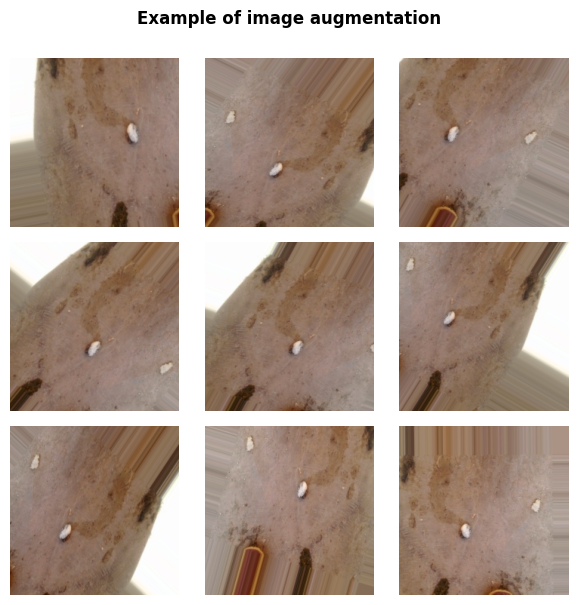

In [12]:
# Visualize image augmentation

# Load and preprocess an example image
img_path = os.path.join(train_healthy_dir, train_healthy_fnames[2])
img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))  # Load the image (PIL format)
x = img_to_array(img)            # Convert the image to a numpy array (shape: (224, 224, 3))
x = x.reshape((1,) + x.shape)   # Add an extra dimension to match batch size

# Define the number of plots
num_plots = 9

# Create a single figure with subplots
fig, axs = plt.subplots(3, 3, figsize=(6, 6))

# Generate batches of randomly transformed images and display them
i = 0
for batch in train_datagen.flow(x, batch_size=1, seed=42):
    axs.flat[i].imshow(array_to_img(batch[0]))
    axs.flat[i].axis('off')
    i += 1
    if i == num_plots:
        break

# Add a title to the plot
fig.suptitle('Example of image augmentation', fontsize=12, weight='bold', y=1.001 )
plt.tight_layout()
plt.show();

# CNN architectures

The architecture designed for the compared models consists of the following layers:

| Layer (type)                   | Output Shape           |       Param |
|--------------------------------|------------------------|---------------|
|conv2d (Conv2D)                 | (None, 222, 222, 16)   |           448 |
|max_pooling2d (MaxPooling2D)    | (None, 111, 111, 16)   |             0 |
|conv2d_1 (Conv2D)               | (None, 109, 109, 32)   |         4,640 |
|max_pooling2d_1 (MaxPooling2D)  | (None, 54, 54, 32)     |             0 |
|conv2d_2 (Conv2D)               | (None, 52, 52, 64)     |        18,496 |
|max_pooling2d_2 (MaxPooling2D)  | (None, 26, 26, 64)     |             0 |
|conv2d_3 (Conv2D)               | (None, 24, 24, 128)    |        73,856 |
|max_pooling2d_3 (MaxPooling2D)  | (None, 12, 12, 128)    |             0 |
|flatten (Flatten)               | (None, 18432)          |             0 |
|dense (Dense)  - **regularizer**   | (None, 512)            |     9,437,696 |
|dropout (Dropout) - **opcional**  | (None, 512)            |             0 |
|dense_1 (Dense)                 | (None, 2)              |         1,026 |




Each model has **9,536,162 (36.38 MB)** parameters to optimize. Additionally, some include a Dropout layer, as well as different combinations of regularizers. To compile the models, the Adam and RMSprop optimizers were used. In all cases, accuracy (Accuracy) is employed as the metric for comparison.

In [13]:
# Create the models
def create_cnn_model(custom_name, loss, optimizer, dropout, activation_output, regularization_type):
    """
    Creates a CNN model using the Keras Sequential API.

    Args:
        loss (str): Name of the loss function to use for training.
        optimizer (str): Name of the optimizer to use for training.
        dropout (float): Dropout rate to use for regularization (0 = no dropout).
        activation_output (str): Name of the activation function to use for the output layer.
        regularization_type (str): Type of regularization to use for the dense layer ('l1', 'l2', 'l1_l2', or 'none').

    Returns:
        model (tf.keras.models.Sequential): The compiled CNN model.
    """
    model = Sequential()
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())

    # Dynamic architecture
    if regularization_type == 'l1':
        model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l1(0.01), name='dense_l1'))
    elif regularization_type == 'l2':
        model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='dense_l2'))
    elif regularization_type == 'l1_l2':
        model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), name='dense_l1_l2'))
    else:
        model.add(Dense(512, activation='relu', name='dense'))

    # Adding Dropout
    if dropout:
        model.add(Dropout(dropout, seed=42))

    # Output
    model.add(Dense(2, activation=activation_output, name='output'))

    # Model compilation
    metrics = ['accuracy', tf.keras.metrics.Recall()]
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    # Add the name of the model as an attribute
    model.custom_name = custom_name

    return model

In [14]:
# Define models to evaluate
models_info = [
    ("Model 1", "categorical_crossentropy", tf.keras.optimizers.Adam(learning_rate=0.001),    0.5,  "softmax", 'l2'),
    ("Model 2", "categorical_crossentropy", tf.keras.optimizers.Adam(learning_rate=0.0001),   0.5,  "softmax", 'l2'),
    ("Model 3", "categorical_crossentropy", tf.keras.optimizers.Adam(learning_rate=0.001),    None, "softmax", 'l2'),
    ("Model 4", "categorical_crossentropy", tf.keras.optimizers.Adam(learning_rate=0.001),    0.5,  "softmax", 'l1'),
    ("Model 5", "categorical_crossentropy", tf.keras.optimizers.Adam(learning_rate=0.001),    0.5,  "softmax", 'l1_l2'),
    ("Model 6", "categorical_crossentropy", tf.keras.optimizers.Adam(learning_rate=0.001),    0.5,  "softmax",  False),

    ("Model 7", "categorical_crossentropy", tf.keras.optimizers.RMSprop(learning_rate=0.001),  0.5,  "softmax", 'l2'),
    ("Model 8", "categorical_crossentropy", tf.keras.optimizers.RMSprop(learning_rate=0.0001), 0.5,  "softmax", 'l2'),
    ("Model 9", "categorical_crossentropy", tf.keras.optimizers.RMSprop(learning_rate=0.001),  None, "softmax", 'l2'),
    ("Model 10", "categorical_crossentropy", tf.keras.optimizers.RMSprop(learning_rate=0.001), 0.5,  "softmax", 'l1'),
    ("Model 11", "categorical_crossentropy", tf.keras.optimizers.RMSprop(learning_rate=0.001), 0.5,  "softmax", 'l1_l2'),
    ("Model 12", "categorical_crossentropy", tf.keras.optimizers.RMSprop(learning_rate=0.001), 0.5,  "softmax",  False),
]

In [15]:
# Create, compile and summarize the models
for custom_name, loss, optimizer, dropout, activation_output, regularization_type in models_info:
    model = create_cnn_model(custom_name, loss, optimizer, dropout, activation_output, regularization_type)

    # Summarize the model
    print(f"\n{custom_name} Summary\n{'--'*20}")
    model.summary()


Model 1 Summary
----------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l2 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 2 Summary
----------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l2 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 3 Summary
----------------------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l2 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 4 Summary
----------------------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l1 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 5 Summary
----------------------------------------


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l1_l2 (Dense)             │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 6 Summary
----------------------------------------


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 7 Summary
----------------------------------------


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l2 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 8 Summary
----------------------------------------


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l2 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 9 Summary
----------------------------------------


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l2 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 10 Summary
----------------------------------------


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l1 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 11 Summary
----------------------------------------


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l1_l2 (Dense)             │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 12 Summary
----------------------------------------


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)

# Training the models

## Callbacks

In [16]:
# Define the EarlyStopping callback to stop training when the validation loss stops improving
#earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
earlystop = EarlyStopping(monitor='val_accuracy',patience=20, verbose=1, restore_best_weights=True)

# Define the ModelCheckpoint callback to save the best model based on the validation accuracy
checkpoint = ModelCheckpoint("best_base_model.keras", monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

## Training

In [17]:
# Train the models
results = []
models = []
training_histories = []

for i, (custom_name, loss, optimizer, dropout, activation_output, use_regularization) in enumerate(models_info):
    # Create and compile the model
    model = create_cnn_model(custom_name, loss, optimizer, dropout, activation_output, use_regularization)
    models.append(model)
    model.custom_name = custom_name

    # Train the model
    print(f"\nModel {i+1}\n{'--'*20}")
    history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        verbose=0,
        callbacks=[checkpoint, earlystop],
    )

    # Store the training history
    training_histories.append(history)

    # Display the best accuracy
    history_model = pd.DataFrame(history.history)
    print(f"\nThe best accuracy:")
    history_model_acc = history_model.sort_values(by='accuracy', ascending=False)
    display(history_model_acc.head(1))

    # Display the best validation accuracy
    print(f"\nThe best validation accuracy:")
    history_model_val_acc = history_model.sort_values(by='val_accuracy', ascending=False)
    display(history_model_val_acc.head(1))

    # Display the best validation recall
    print(f"\nThe best validation recall:")
    val_recall_column = [col for col in history_model.columns if col.startswith('val_recall')]
    history_model_val_rec = history_model.sort_values(by=val_recall_column[0], ascending=False)
    display(history_model_val_rec.head(1))

    # Store the results
    results.append((custom_name, history))


Model 1
----------------------------------------


2024-05-30 20:18:38.898447: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49295: 4.25514, expected 3.61721
2024-05-30 20:18:38.898504: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49296: 5.13285, expected 4.49491
2024-05-30 20:18:38.898514: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49346: 5.29403, expected 4.65609
2024-05-30 20:18:38.898522: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49349: 5.09757, expected 4.45964
2024-05-30 20:18:38.898530: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49350: 5.27288, expected 4.63495
2024-05-30 20:18:38.898538: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49351: 5.07595, expected 4.43801
2024-05-30 20:18:38.898545: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49366: 5.21611, expected 4.57817
2024-05-30 20:18:38.898554:

Restoring model weights from the end of the best epoch: 31.

The best accuracy:


,accuracy,loss,recall_12,val_accuracy,val_loss,val_recall_12
26,0.89375,0.351849,0.89375,0.769912,0.461456,0.769912



The best validation accuracy:


,accuracy,loss,recall_12,val_accuracy,val_loss,val_recall_12
30,0.8625,0.37062,0.8625,0.90625,0.314674,0.90625



The best validation recall:


,accuracy,loss,recall_12,val_accuracy,val_loss,val_recall_12
30,0.8625,0.37062,0.8625,0.90625,0.314674,0.90625



Model 2
----------------------------------------
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 26.

The best accuracy:


,accuracy,loss,recall_13,val_accuracy,val_loss,val_recall_13
20,0.916667,0.376385,0.916667,0.902655,0.395977,0.902655



The best validation accuracy:


,accuracy,loss,recall_13,val_accuracy,val_loss,val_recall_13
25,0.889063,0.345447,0.889063,0.915625,0.357231,0.915625



The best validation recall:


,accuracy,loss,recall_13,val_accuracy,val_loss,val_recall_13
25,0.889063,0.345447,0.889063,0.915625,0.357231,0.915625



Model 3
----------------------------------------
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.

The best accuracy:


,accuracy,loss,recall_14,val_accuracy,val_loss,val_recall_14
14,0.86875,0.353001,0.86875,0.849558,0.376323,0.849558



The best validation accuracy:


,accuracy,loss,recall_14,val_accuracy,val_loss,val_recall_14
18,0.859375,0.371756,0.859375,0.878125,0.32623,0.878125



The best validation recall:


,accuracy,loss,recall_14,val_accuracy,val_loss,val_recall_14
18,0.859375,0.371756,0.859375,0.878125,0.32623,0.878125



Model 4
----------------------------------------
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.

The best accuracy:


,accuracy,loss,recall_15,val_accuracy,val_loss,val_recall_15
17,0.867188,11.483343,0.867188,0.867257,11.440578,0.867257



The best validation accuracy:


,accuracy,loss,recall_15,val_accuracy,val_loss,val_recall_15
18,0.84375,11.458434,0.84375,0.871875,11.501937,0.871875



The best validation recall:


,accuracy,loss,recall_15,val_accuracy,val_loss,val_recall_15
18,0.84375,11.458434,0.84375,0.871875,11.501937,0.871875



Model 5
----------------------------------------
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.

The best accuracy:


,accuracy,loss,recall_16,val_accuracy,val_loss,val_recall_16
18,0.860937,11.229587,0.860937,0.846875,11.300655,0.846875



The best validation accuracy:


,accuracy,loss,recall_16,val_accuracy,val_loss,val_recall_16
11,0.828125,11.748792,0.828125,0.876106,11.540039,0.876106



The best validation recall:


,accuracy,loss,recall_16,val_accuracy,val_loss,val_recall_16
11,0.828125,11.748792,0.828125,0.876106,11.540039,0.876106



Model 6
----------------------------------------
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.

The best accuracy:


,accuracy,loss,recall_17,val_accuracy,val_loss,val_recall_17
16,0.882812,0.294134,0.882812,0.8375,0.353568,0.8375



The best validation accuracy:


,accuracy,loss,recall_17,val_accuracy,val_loss,val_recall_17
18,0.873217,0.311539,0.873217,0.909375,0.243002,0.909375



The best validation recall:


,accuracy,loss,recall_17,val_accuracy,val_loss,val_recall_17
18,0.873217,0.311539,0.873217,0.909375,0.243002,0.909375



Model 7
----------------------------------------
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.

The best accuracy:


,accuracy,loss,recall_18,val_accuracy,val_loss,val_recall_18
18,0.858954,0.383111,0.858954,0.89375,0.348746,0.89375



The best validation accuracy:


,accuracy,loss,recall_18,val_accuracy,val_loss,val_recall_18
18,0.858954,0.383111,0.858954,0.89375,0.348746,0.89375



The best validation recall:


,accuracy,loss,recall_18,val_accuracy,val_loss,val_recall_18
18,0.858954,0.383111,0.858954,0.89375,0.348746,0.89375



Model 8
----------------------------------------
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.

The best accuracy:


,accuracy,loss,recall_19,val_accuracy,val_loss,val_recall_19
16,0.842188,0.893082,0.842188,0.859375,0.80237,0.859375



The best validation accuracy:


,accuracy,loss,recall_19,val_accuracy,val_loss,val_recall_19
16,0.842188,0.893082,0.842188,0.859375,0.80237,0.859375



The best validation recall:


,accuracy,loss,recall_19,val_accuracy,val_loss,val_recall_19
16,0.842188,0.893082,0.842188,0.859375,0.80237,0.859375



Model 9
----------------------------------------
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.

The best accuracy:


,accuracy,loss,recall_20,val_accuracy,val_loss,val_recall_20
13,0.859375,0.362756,0.859375,0.796875,0.420911,0.796875



The best validation accuracy:


,accuracy,loss,recall_20,val_accuracy,val_loss,val_recall_20
17,0.842188,0.384646,0.842188,0.911504,0.339748,0.911504



The best validation recall:


,accuracy,loss,recall_20,val_accuracy,val_loss,val_recall_20
17,0.842188,0.384646,0.842188,0.911504,0.339748,0.911504



Model 10
----------------------------------------
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.

The best accuracy:


,accuracy,loss,recall_21,val_accuracy,val_loss,val_recall_21
17,0.826563,43.539196,0.826563,0.876106,41.867859,0.876106



The best validation accuracy:


,accuracy,loss,recall_21,val_accuracy,val_loss,val_recall_21
17,0.826563,43.539196,0.826563,0.876106,41.867859,0.876106



The best validation recall:


,accuracy,loss,recall_21,val_accuracy,val_loss,val_recall_21
17,0.826563,43.539196,0.826563,0.876106,41.867859,0.876106



Model 11
----------------------------------------
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.

The best accuracy:


,accuracy,loss,recall_22,val_accuracy,val_loss,val_recall_22
12,0.55625,47.878712,0.55625,0.509375,46.815876,0.509375



The best validation accuracy:


,accuracy,loss,recall_22,val_accuracy,val_loss,val_recall_22
8,0.534375,47.881058,0.534375,0.557522,46.651615,0.557522



The best validation recall:


,accuracy,loss,recall_22,val_accuracy,val_loss,val_recall_22
8,0.534375,47.881058,0.534375,0.557522,46.651615,0.557522



Model 12
----------------------------------------
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.

The best accuracy:


,accuracy,loss,recall_23,val_accuracy,val_loss,val_recall_23
13,0.880208,0.263564,0.880208,0.84375,0.285189,0.84375



The best validation accuracy:


,accuracy,loss,recall_23,val_accuracy,val_loss,val_recall_23
17,0.823438,0.343382,0.823438,0.858407,0.333553,0.858407



The best validation recall:


,accuracy,loss,recall_23,val_accuracy,val_loss,val_recall_23
17,0.823438,0.343382,0.823438,0.858407,0.333553,0.858407


# Evaluation and testing

## Histories plot

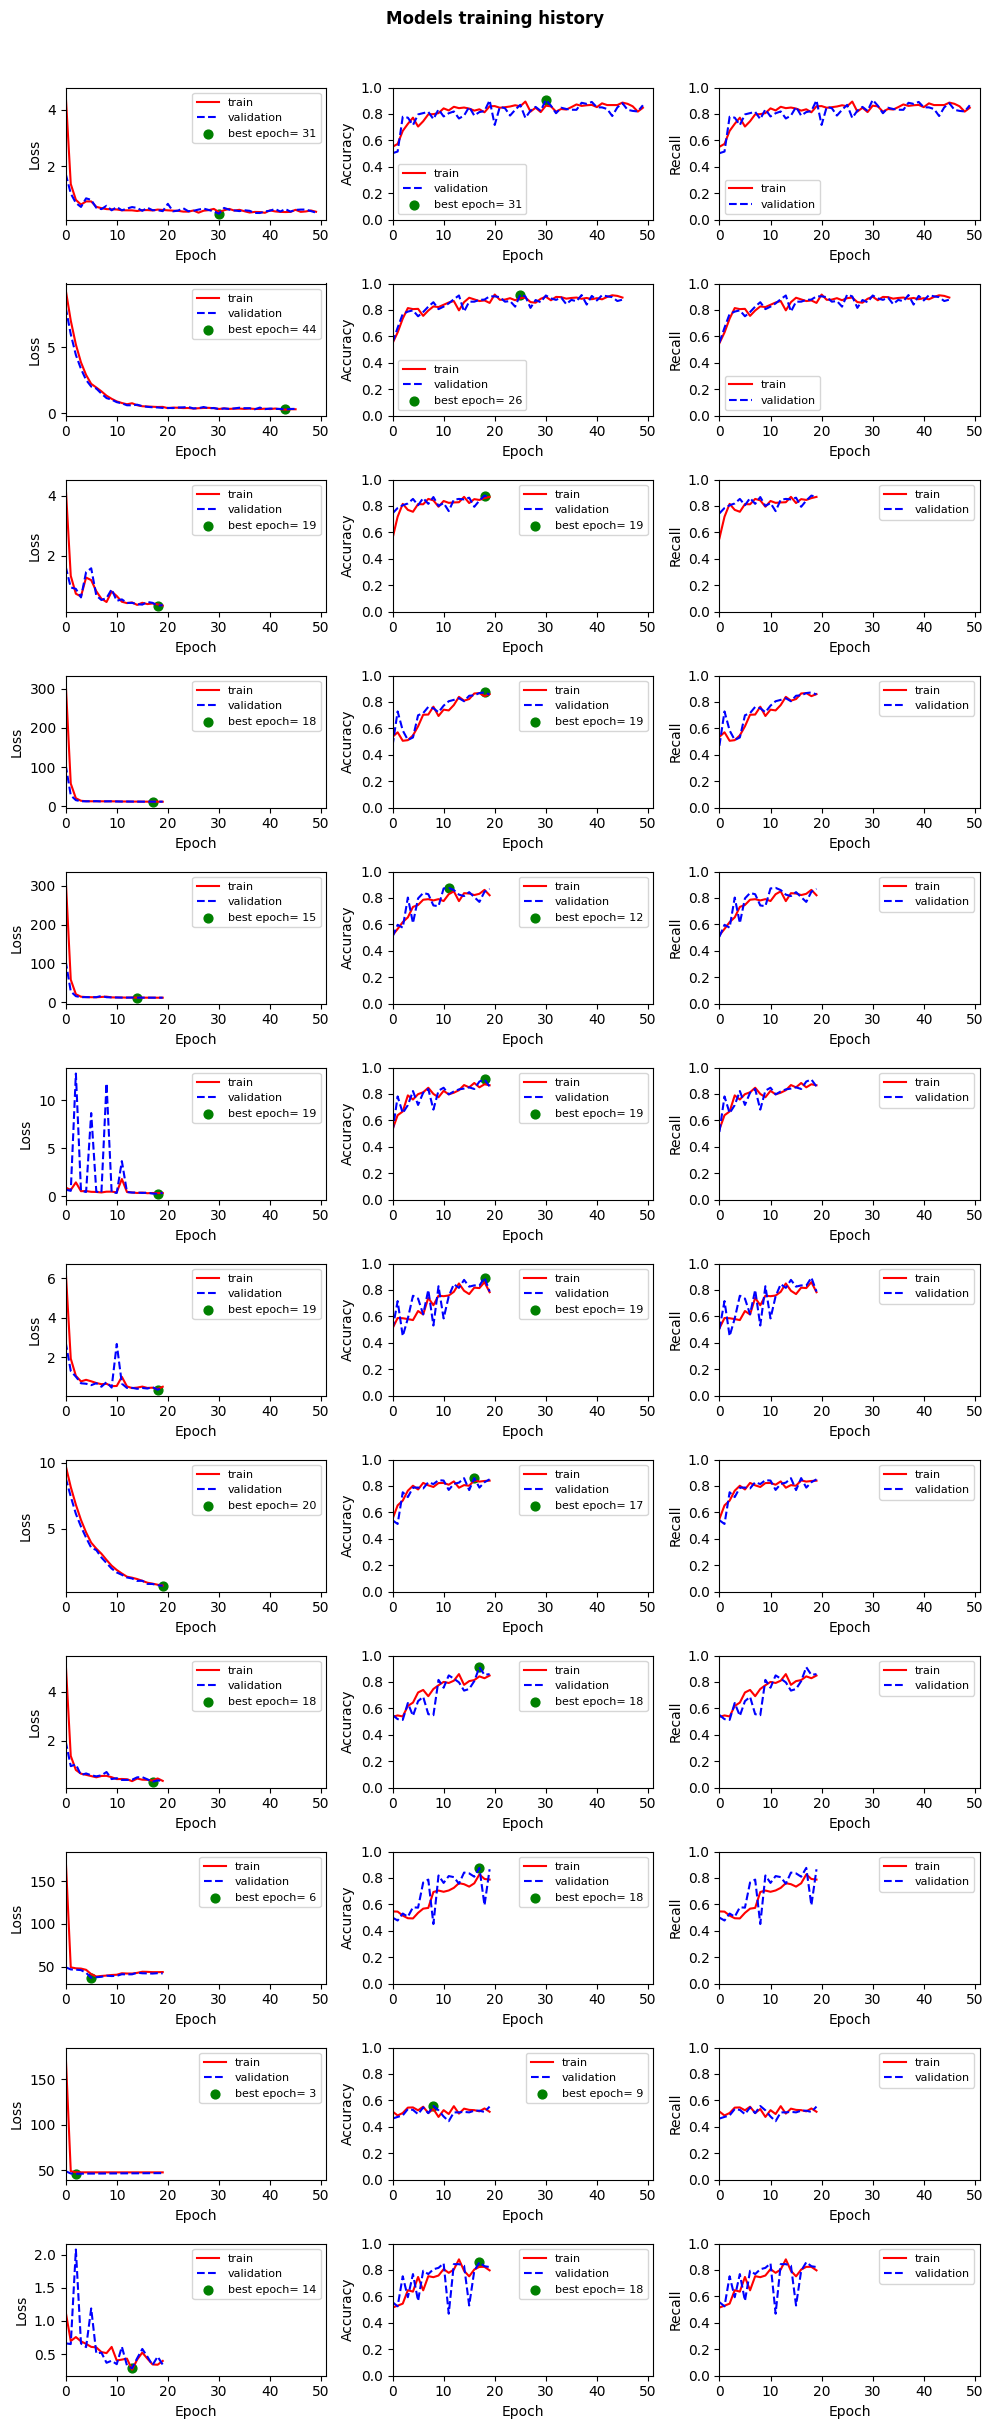

In [18]:
# Get histories for each model
histories = [result[1] for result in results]
titles = [result[0] for result in results]

# Figures
fig, axes = plt.subplots(len(histories),3, figsize= (10,24))

# Get x-axis lenght
max_epoch = max([max(history.epoch) for history in histories])

# Plot the results for every epoch of each model
for i, history in enumerate(histories):

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        # Found best epochs
        val_lowest_index = hist['val_loss'].idxmin()
        val_lowest = hist['val_loss'].min()
        index_loss = hist['epoch'][val_lowest_index]

        val_max_index = hist['val_accuracy'].idxmax()
        val_max = hist['val_accuracy'].max()
        index_acc = hist['epoch'][val_max_index]

        #val_recall_max_index = hist['val_recall'].idxmax()
        #val_recall_max = hist['val_recall'].max()
        #index_recall = hist['epoch'][val_recall_max_index]

        loss_label = f'best epoch= {str(index_loss + 1)}'
        acc_label = f'best epoch= {str(index_acc + 1)}'

        # Plot loss
        axes[i,0].plot(hist['epoch'], hist['loss'], label= 'train', ls ='-', color = 'red')
        axes[i,0].plot(hist['epoch'], hist['val_loss'], label = 'validation',ls ='--', color = 'blue')
        axes[i,0].scatter(index_loss, val_lowest,s=40, c='green', label=loss_label)
        axes[i,0].set_ylabel('Loss')

        # Plot accuracy
        axes[i,1].plot(hist['epoch'], hist['accuracy'], label= 'train',  ls ='-', color = 'red')
        axes[i,1].plot(hist['epoch'], hist['val_accuracy'], label = 'validation', ls = '--', color = 'blue')
        axes[i,1].scatter(index_acc, val_max, s=40, c='green', label=acc_label)
        axes[i,1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        axes[i,1].set_ylabel('Accuracy')

        # Plot recall
        val_recall_columns = [col for col in hist.columns if 'recall' in col]
        if val_recall_columns:
            axes[i,2].plot(hist['epoch'], hist[val_recall_columns[0]], label= 'train',  ls ='-', color = 'red')
            axes[i,2].plot(hist['epoch'], hist[val_recall_columns[1]], label= 'validation', ls = '--', color = 'blue')
            axes[i,2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axes[i,2].set_ylabel('Recall')
        else:
            print(f"No se encontraron columnas de recall en la historia del modelo {titles[i]}")

        # Styling
        for j in range(3):
            axes[i,j].set_xlabel('Epoch')
            axes[i,j].legend(fontsize = 8)
            axes[i,j].set_xlim([0, max_epoch+2])

            #plt.figtext(0.5, ((i*-0.10) + 0.97), titles[i], va="center", ha="center", size=10)

fig.suptitle("Models training history", fontsize = 12, weight='bold', y= 1.01)
plt.tight_layout()
plt.show();

## Confussion matrix

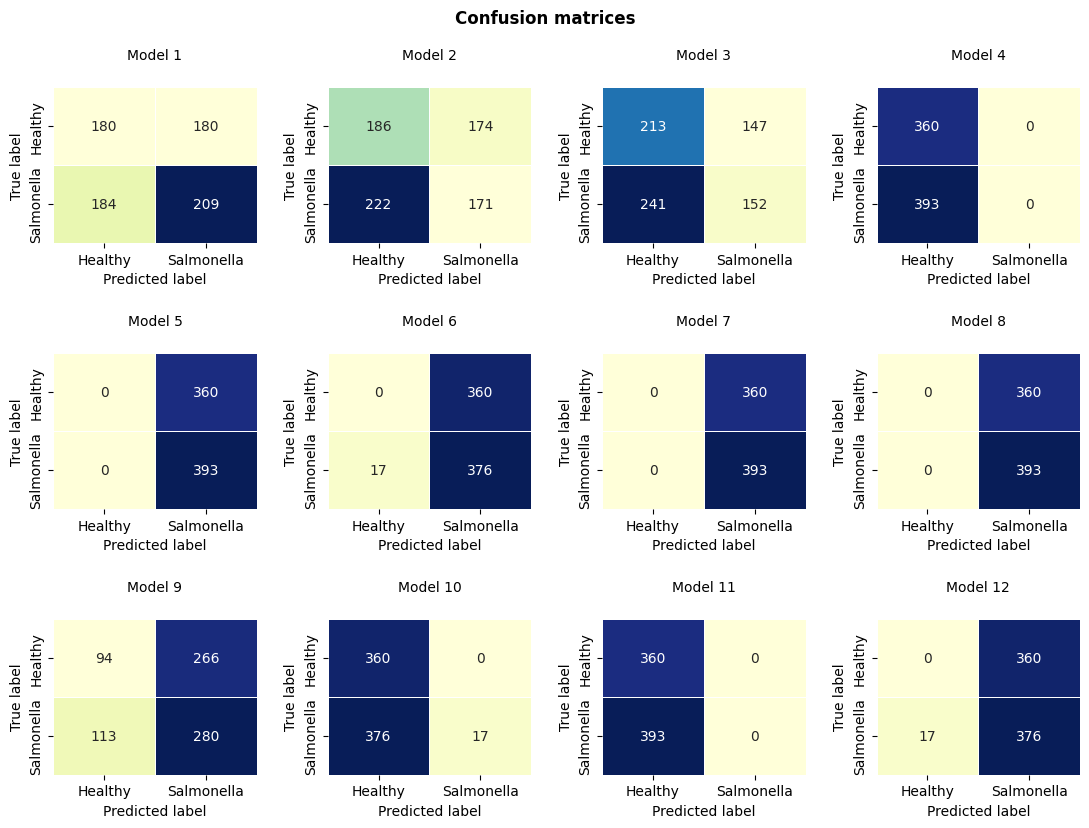

In [19]:
# Set figure
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(11, 8))

# Get x-axis lenght
max_epoch = max([max(history.epoch) for history in histories])

# Plot the results for every epoch of each model
for i, history in enumerate(histories):

    # Evaluate the model on the validation set
    y_pred = history.model.predict(validation_generator, verbose = 0)
    y_pred = np.argmax(y_pred, axis=1)

    # Get the true labels for the validation set
    y_true = validation_generator.classes

    # Calculate and plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, linewidths=.5, fmt='.0f', cbar=False, ax=axes[i//4, i%4], cmap=plt.cm.YlGnBu, xticklabels=['Healthy', 'Salmonella'],yticklabels=['Healthy', 'Salmonella'])

    # Add title and labels
    axes[i//4, i%4].set_title(titles[i], fontsize=10, pad=20)
    axes[i//4, i%4].set_xlabel('Predicted label', fontsize=10)
    axes[i//4, i%4].set_ylabel('True label', fontsize=10)

# Styling
fig.tight_layout(w_pad=2.0, h_pad=2.0)
fig.suptitle("Confusion matrices", fontsize=12, y=1.03, weight='bold')
plt.show();

## Validation metrics

In [20]:
# Get histories for each model
histories = [result[-1] for result in results]
titles = [result[0] for result in results]

# Evaluate each model on the validation set and store the results in a dataframe
results_df = pd.DataFrame(columns=['Model', 'Val Loss', 'Val Accuracy', 'Val Recall', 'Time (s)', 'Params'])
for i, (model, history) in enumerate(zip(models, histories)):

    # Get the current time before evaluating the model
    start_eval_time = time.time()

    # Evaluate the model on the validation set
    val_loss, val_accuracy, val_recall = model.evaluate(test_generator, verbose=0)

    # Get the current time after evaluating the model
    end_eval_time = time.time()
    eval_time = end_eval_time - start_eval_time

    # Count params of each model
    params = model.count_params()

    # Store the results in the dataframe
    results_df.loc[i] = [titles[i], val_loss, val_accuracy, val_recall, eval_time, params]

results_df = results_df.sort_values(by='Val Accuracy', ascending=False)
results_df

2024-05-30 20:53:04.050152: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49295: 5.26532, expected 4.63831
2024-05-30 20:53:04.050211: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49350: 4.81216, expected 4.18515
2024-05-30 20:53:04.050221: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49464: 4.97103, expected 4.34402
2024-05-30 20:53:04.050234: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50339: 5.20791, expected 4.5809
2024-05-30 20:53:04.050243: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50505: 5.04376, expected 4.41675
2024-05-30 20:53:04.050252: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50747: 5.25685, expected 4.62984
2024-05-30 20:53:04.050261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50793: 5.15653, expected 4.52952
2024-05-30 20:53:04.050271: 

,Model,Val Loss,Val Accuracy,Val Recall,Time (s),Params
1,Model 2,0.391831,0.877470,0.877470,0.776788,9536162
0,Model 1,0.336464,0.865613,0.865613,2.046527,9536162
2,Model 3,3.912050,0.644269,0.644269,0.786301,9536162
9,Model 10,49.288391,0.592885,0.592885,0.819738,9536162
8,Model 9,1.932321,0.592885,0.592885,0.842720,9536162
7,Model 8,8.830333,0.521739,0.521739,0.816862,9536162
4,Model 5,106.127289,0.521739,0.521739,0.945806,9536162
6,Model 7,2.692080,0.521739,0.521739,0.769413,9536162
3,Model 4,105.544983,0.478261,0.478261,0.879638,9536162
10,Model 11,49.175117,0.478261,0.478261,0.836544,9536162


## Visualize predictions

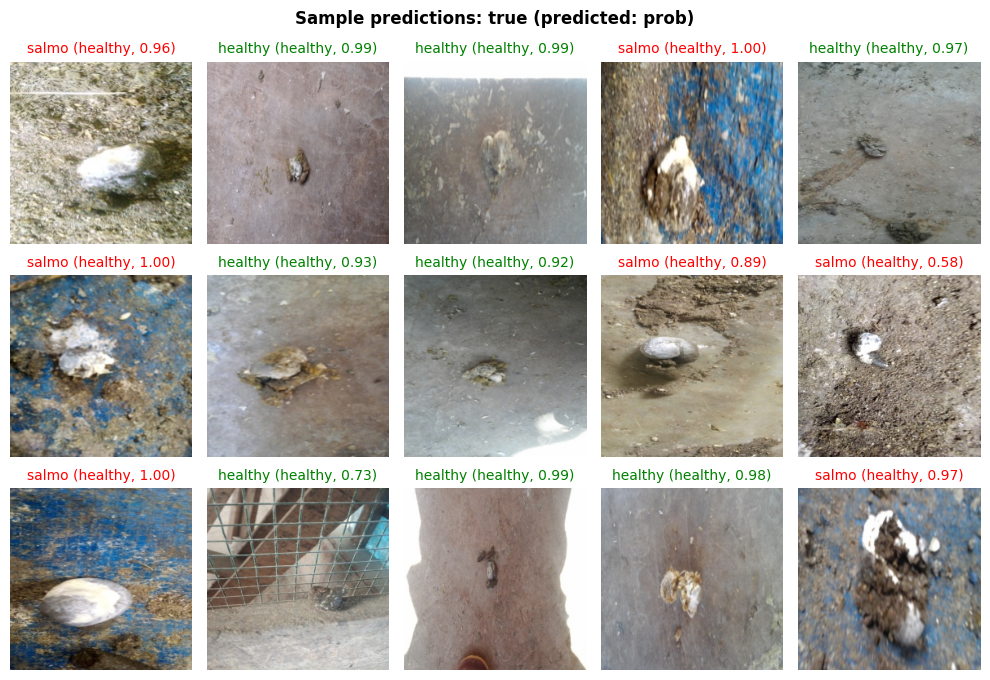

In [21]:
# Cargar el mejor modelo guardado en el archivo "best_model.keras"
best_base_model = load_model("best_base_model.keras")

# Get probabilities and predictions labels for test images
y_prob = best_base_model.predict(test_generator, verbose=0)
y_hat = np.argmax(y_prob, axis=1)

# Define class names
class_names = ['healthy', 'salmo']

# Create figure and subplots
fig, axs = plt.subplots(3, 5, figsize=(10, 7))
axs = axs.ravel()

# Choose random images from test set
indices = np.random.choice(len(test_generator.filenames), size=15, replace=False)

# Loop through images and display them with their predicted and true labels
for i, index in enumerate(indices):
    # Get image path and load image
    img_path = os.path.join(test_dir, test_generator.filenames[index])
    img = mpimg.imread(img_path)

    # Get true label of image
    if 'healthy' in os.path.basename(img_path):
        true_label = 'healthy'
    elif 'salmo' in os.path.basename(img_path):
        true_label = 'salmo'
    else:
        print('La imagen no pertenece a ninguna clase')

    # Get predicted label of image
    pred_label = class_names[y_hat[index]]
    pred_prob = y_prob[index][y_hat[index]]
    pred_label = 'salmo' if pred_label == 1 else 'healthy'

    # Display image in corresponding subplot
    ax = axs[i]
    ax.imshow(img)
    ax.set_title(f"{true_label} ({pred_label}, {pred_prob:.2f})", color="green" if pred_label == true_label else "red", fontsize=10)
    ax.axis('off')

# Add title to figure
fig.suptitle('Sample predictions: true (predicted: prob)', weight='bold', fontsize=12)
plt.tight_layout()
plt.show();

# Best model info

In [22]:
# Load best_model.keras object
best_base_model = load_model('best_base_model.keras')
best_base_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_l2 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,608,488 (109.13 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,072,326 (72.76 MB)